In [ ]:
'''
Data augmentation, noise addition
Descriptors
Model perfomance
Fine tuning
'''

In [ ]:
'''
In this notebook, we load the training data, which the models had not seen before.
For each model, we train it on the training set then test it on the test set. We obtai its perfomance based on the precision, 
recall, f1 score and the accuracy.
We then ensemble the models to find the perfomance
'''

In [1]:
#for array manipulations
import numpy as np
import pandas as pd
#for image processing
import cv2 
#for displaying images
import matplotlib.pyplot as plt
#to display images in this notebook, not in a separate window
%matplotlib inline
import seaborn as sns
#to access system resources such as directories
import os
#This wilallow us to get the training time of each model
import time

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix, recall_score,
            f1_score, precision_score, precision_recall_curve, precision_recall_fscore_support)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingClassifier

In [98]:
#The notebooks folder
os.getcwd()

'C:\\Users\\USER\\Documents\\GitHub\\maize-disease-detection\\notebooks'

In [99]:
#set our base directory. This should point to the location of the plant-diseases folder
base_dir = 'C:\\Users\\USER\\Documents\\GitHub\\maize-disease-detection'
#This is where our data is stored
data_folder = os.path.join(base_dir, 'data')
#Points to the folder containing the maize diseseases data
maize_data_folder = os.path.join(data_folder, 'maize')
#Contains our test data in different folders
test_data_folder = os.path.join(data_folder, 'test')
#this will contain our models and other model related data
models_dir = os.path.join(base_dir,'models')

In [6]:
#This function loads 32 images of a particular disease
def get_32(disease):
    '''
    This function loads 32 images from the given directory
    inputs
    ------
        disease: string
            Foder name that could be common_rust, healthy, leaf_spot, nothern_leaf_blight
    outputs
    ........
        disease_images: list
            A list of images for the selected disease
    '''
    #this list will contain the 20 images returned
    disease_images = []
    #path to the images
    disease_images_path = os.path.join(maize_data_folder, disease)
    for image_path in os.listdir(disease_images_path):
        image_path = os.path.join(disease_images_path, image_path)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        disease_images.append(image)
    return disease_images

#This function loads 32 images of a particular disease
def get_test_images(disease):
    '''
    disease:
        A string that could be common_rust, healthy, leaf_spot, nothern_leaf_blight
    ........
    disease_images:
        A list of images for the selected disease
    '''
    #this list will contain the 20 images returned
    disease_images = []
    #path to the images
    disease_images_path = os.path.join(test_data_folder, disease)
    for image_path in os.listdir(disease_images_path)[:30]:
        image_path = os.path.join(disease_images_path, image_path)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        disease_images.append(image)
    return disease_images

#This function will help us plot 10 images
def plot_images(images, title):
    '''
    images: List
        List of images
    title: String
        Title for each image i.e name of disease
    '''
    plt.figure(figsize=(15,6))
    for i in range(10):
        plt.subplot(2,5, i+1)
        plt.imshow(images[i])
        plt.title(title)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
#This function generates ORB features
def extract_features_orb(image, vector_size=32):
    try:
        feature_generator = cv2.ORB_create()
        orb_keypoints = feature_generator.detect(image)
        orb_keypoints = orb_keypoints[:32]
        orb_keypoints, orb_descriptors = feature_generator.compute(image, orb_keypoints)
        orb_descriptors = orb_descriptors.flatten()
        #The descriptor vector size is 128
        needed_size = (vector_size*128)
        if orb_descriptors.size < needed_size:
            #If we have less than 32 keypoints, add zeros to the end of our vector
            orb_descriptors = np.concatenate([orb_descriptors, np.zeros(needed_size - orb_descriptors.size)])
    except cv2.error as e:
        print(f'Error: {e}')
        return None
    return orb_descriptors

#This function generates KAZE features
def extract_features_kaze(image, vector_size=32):
    try:
        feature_generator = cv2.KAZE_create()
        kaze_keypoints = feature_generator.detect(image)
        kaze_keypoints = kaze_keypoints[:32]
        kaze_keypoints, kaze_descriptors = feature_generator.compute(image, kaze_keypoints)
        kaze_descriptors = kaze_descriptors.flatten()
        #The descriptor vector size is 128
        needed_size = (vector_size*128)
        if kaze_descriptors.size < needed_size:
            #If we have less than 32 keypoints, add zeros to the end of our vector
            kaze_descriptors = np.concatenate([kaze_descriptors, np.zeros(needed_size - kaze_descriptors.size)])
    except cv2.error as e:
        print(f'Error: {e}')
        return None
    return kaze_descriptors

def extract_features_hog(image, feature_size=4096):
    hog = cv2.HOGDescriptor()
    features = hog.compute(image)
    required_features = features[:feature_size].ravel()
    return required_features

#Let us extraxt KAZE features
def extract_features(algorithm=0):
    '''
    Algorithm:
        1 for ORB
        0 for KAZE
        2 for HOG
    '''
    #Now let us perform these steps for all the 32 images loaded
    #This will contain all our images
    all_images = []
    #This will contain all our labels
    all_labels = []
    labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, image_folder in enumerate([common_rust_images, healthy_images, leaf_spot_images, nothern_leaf_blight_images]):
        for image in image_folder:
            all_images.append(image)
            all_labels.append(labels[i])
    features, labels = [], []
    for i, image in enumerate(all_images):
        image_features = []
        try:
            if algorithm == 1:
                image_features = extract_features_orb(image)
            elif algorithm == 0:
                image_features = extract_features_kaze(image)
            else:
                image_features = extract_features_hog(image)
            image_label = all_labels[i]
            features.append(image_features)
            labels.append(image_label)
        except AttributeError as e:
            print(e)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

#Let us extraxt KAZE features
def extract_features2(algorithm=0):
    '''
    Algorithm:
        1 for ORB
        0 for KAZE
        2 for HOG
    '''
    #Now let us perform these steps for all the 32 images loaded
    #This will contain all our images
    all_images = []
    #This will contain all our labels
    all_labels = []
    labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, image_folder in enumerate([common_rust_images, healthy_images, leaf_spot_images, nothern_leaf_blight_images]):
        for image in image_folder:
            all_images.append(image)
            all_labels.append(labels[i])
    features, labels = [], []
    for i, image in enumerate(all_images):
        image_features = []
        try:
            if algorithm == 1:
                image_features = extract_features_orb(image)
            elif algorithm == 0:
                image_features = extract_features_kaze(image)
            else:
                image_features = extract_features_hog(image)
            image_label = all_labels[i]
            features.append(image_features)
            labels.append(image_label)
        except AttributeError as e:
            print(e)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    
    return features, labels

#Let us extraxt KAZE features
def extract_test_features2(algorithm=2):
    '''
    Algorithm:
        1 for ORB
        0 for KAZE
        2 for HOG
    '''
    #Now let us perform these steps for all the 32 images loaded
    #This will contain all our images
    all_images = []
    #This will contain all our labels
    all_labels = []
    labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, image_folder in enumerate([common_rust_test_images, healthy_test_images, leaf_spot_test_images, nothern_leaf_blight_test_images]):
        for image in image_folder:
            all_images.append(image)
            all_labels.append(labels[i])
    features, labels = [], []
    for i, image in enumerate(all_images):
        image_features = []
        try:
            if algorithm == 1:
                image_features = extract_features_orb(image)
            elif algorithm == 0:
                image_features = extract_features_kaze(image)
            else:
                image_features = extract_features_hog(image)
            image_label = all_labels[i]
            features.append(image_features)
            labels.append(image_label)
        except AttributeError as e:
            print(e)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    labels = LabelEncoder().fit_transform(labels)
    
    return features, labels

#This method gives us a rough idea about the accuracy of the base models and their raining times
def train_base_models(X_train, y_train, X_test, y_test):
    '''
    '''
    model_accuracy = []
    train_time = []
    model_names = []
    for i, classifier in enumerate(models):
        try:
            #Let us train the model and get the training time
            start_time = time.time()
            classifier.fit(X_train, y_train)
            stop_time = time.time()
            train_time.append(stop_time - start_time)
            predictions = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            model_accuracy.append(round(accuracy, 3))
            model_names.append(names[i])
            print(f'{names[i]}: {round(accuracy, 3)}')
        except Exception as e:
            print(f'Could not train {names[i]} because of {e}')
    df = pd.DataFrame({'Model':model_names, 'Accuracy':model_accuracy, 'Train Time':train_time})
    df = df.sort_values(by=['Accuracy'], ascending=False)
    return df

#This method gives us a rough idea about the accuracy of the base models and their raining times
def train_base_models2(features, labels):
    '''
    '''
    #We use cross-validation
    model_accuracy = []
    train_time = []
    model_names = []
    
    for i, classifier in enumerate(models):
        try:
            #Let us train the model and get the training time
            start_time = time.time()
            scores = cross_val_score(classifier, features, labels, scoring='accuracy', cv=10)
            stop_time = time.time()
            train_time.append(stop_time - start_time)
            model_accuracy.append(round(np.mean(scores), 3))
            model_names.append(names[i])
            print(f'{names[i]}: {round(np.mean(scores), 3)}')
        except Exception as e:
            print(f'Could not train {names[i]} because of {e}')
    df = pd.DataFrame({'Model':model_names, 'Accuracy':model_accuracy, 'Train Time':train_time})
    df = df.sort_values(by=['Accuracy'], ascending=False)
    return df

#This function returns the model perfomance on kaze data
def kaze_results(algorithm=0):
    models_names = []
    model_perfomance = []
    train_time = []
    for i, model in enumerate(kaze_models):
        start = time.time()
        scores = cross_val_score(model, X,y, scoring='accuracy', cv=10)
        stop = time.time()
        models_names.append(model_names[i])
        model_perfomance.append(round(scores.mean(), 2))
        train_time.append((stop - start)/10)
    df = pd.DataFrame({'Model Name':models_names, 'Model Accuracy':model_perfomance, 'Training time':train_time})
    df = df.sort_values(by=['Model Accuracy'], ascending=False)
    return df

#This function returns the model perfomance on hog data
def hog_results(X,y):
    models_names = []
    model_perfomance = []
    train_time = []
    for i, model in enumerate(hog_models):
        start = time.time()
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=10)
        stop = time.time()
        models_names.append(model_names[i])
        model_perfomance.append(round(scores.mean(), 2))
        train_time.append((stop - start)/10)
    df = pd.DataFrame({'Model Name':models_names, 'Model Accuracy':model_perfomance, 'Training Time':train_time})
    df = df.sort_values(by=['Model Accuracy', 'Training Time'], ascending=False)
    return df

#This method generates new features for our training
def get_new_features(model, features, labels):
    kfold = KFold(n_splits=10)
    model_rfecv = RFECV(estimator=model, step=1, cv=kfold, scoring='accuracy')
    model_results = model_rfecv.fit(features, labels) 
    model_grid_scores = model_rfecv.grid_scores_
    model_ranking = model_rfecv.ranking_
    model_features_support = model_rfecv.support_
    model_new_features = []
    for i,feature in enumerate(model_features_support):
        if feature:
            model_new_features.append(i)
    model_features = features[:,model_new_features]
    return model_features


#This method generates new features for our training
def get_new_features2(np_file_name, features):
    features_path = os.path.join(models_dir, np_file_name)
    model_features_support = np.load(features_path)
    model_new_features = []
    for i,feature in enumerate(model_features_support):
        if feature:
            model_new_features.append(i)
    model_features = features[:,model_new_features]
    return model_features

#This method trains a modelon the new features
def train_model(model, features, labels):
    start = time.time()
    scores = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
    stop = time.time()
    t = (stop - start)/10
    return round(scores.mean(), 2), round(t, 4)

In [7]:
#Here we load 32 images for each disease category, used for model training
common_rust_images = get_32('common_rust')
healthy_images = get_32('healthy')
leaf_spot_images = get_32('leaf_spot')
nothern_leaf_blight_images = get_32('nothern_leaf_blight')

In [8]:
#Here we load 30 images for each disease category, used for model testing
common_rust_test_images = get_test_images('common_rust')
healthy_test_images = get_test_images('healthy')
leaf_spot_test_images = get_test_images('leaf_spot')
nothern_leaf_blight_test_images = get_test_images('nothern_leaf_blight')

In [83]:
#The Random Forest classifier after hyperparameter tuning
hog_random_forest = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
#The Logistic Regression classifier after hyperparameter tuning
hog_logistic_regression = LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.1, verbose=0,
                   warm_start=False)
#The K-Nearest Neighbors classifier after hyperparameter tuning
hog_knearest_neighbors = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=1,
                     weights='distance')
#The Linear Support Vector classifier after hyperparameter tuning
hog_linear_svc = LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
          verbose=0)
#The Support Vector classifier after hyperparameter tuning
hog_svc = SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.1,
    verbose=False)
#A list of our models
hog_models = [
    hog_random_forest,
    hog_logistic_regression,
    hog_knearest_neighbors,
    hog_linear_svc,
    hog_svc
]
#A list of the names of our models
model_names = [
    'Random Forest',
    'Logistic Regression',
    'K-Nearest Neighbor',
    'Linear SVC',
    'Support Vector Classifier'
]

In [10]:
#Extract features from the loaded images using hog
X, y = extract_features2(algorithm=2)
#128 instances each with 4096 features
X.shape, y.shape

((128, 4096), (128,))

In [11]:
#Extract features from the loaded test images
test_features, test_labels = extract_test_features2()
#120 instances each with 4096 features
test_features.shape, test_labels.shape

((120, 4096), (120,))

In [12]:
#Selected features for logistic regression model training, after feature selection
lr_features = get_new_features2('lr_support.npy', X)
lr_features.shape

(128, 796)

In [13]:
#Selected features for logistic regression model testing, after feature selection
lr_test_features = get_new_features2('lr_support.npy', test_features)
lr_test_features.shape

(120, 796)

In [14]:
#Selected features for linear support vector model training, after feature selection
linear_svc_features = get_new_features2('linear_svc_support.npy', X)
linear_svc_features.shape

(128, 2566)

In [15]:
#Selected features for linear support vector model testing, after feature selection
linear_svc_test_features = get_new_features2('linear_svc_support.npy', test_features)
linear_svc_test_features.shape

(120, 2566)

In [84]:
#Selected features for support vector model training, after feature selection
svc_features = get_new_features2('svc_support.npy', X)
svc_features.shape

(128, 126)

In [85]:
#Selected features for support vector model testing, after feature selection
svc_test_features = get_new_features2('svc_support.npy', test_features)
svc_test_features.shape

(120, 126)

In [ ]:
'''
For each model, we are going to:
1. Train it
2. Find the training time
3. Test it:
4. Discover the type of errors it makes
5. Find out its robustness to noise:
    We will add noise to the images as well as transform them and find out how well the model does
6. Choose the best 3 and ensemble them
'''

In [18]:
'''
We start with Logistic Regression
1. Train time
2. Accuracy
'''
#Train the model and determine the traiing time
start = time.time()
hog_logistic_regression.fit(lr_features, y)
stop = time.time()
train_time = round((stop - start), 4)
train_time

0.2376

In [19]:
#Test the model accuracy on the test set
predictions = cross_val_predict(hog_logistic_regression, lr_test_features, test_labels, cv=10)
accuracy_score(predictions, test_labels)

0.6083333333333333

In [20]:
'''
Here we just modified this function to return al the features and labels
'''
def extract_features_z(algorithm=0):
    '''
    Algorithm:
        1 for ORB
        0 for KAZE
        2 for HOG
    '''
    #Now let us perform these steps for all the 32 images loaded
    #This will contain all our images
    all_images = []
    #This will contain all our labels
    all_labels = []
    labels = ['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']
    for i, image_folder in enumerate([common_rust_images, healthy_images, leaf_spot_images, nothern_leaf_blight_images]):
        for image in image_folder:
            all_images.append(image)
            all_labels.append(labels[i])
    features, labels = [], []
    for i, image in enumerate(all_images):
        image_features = []
        try:
            if algorithm == 1:
                image_features = extract_features_orb(image)
            elif algorithm == 0:
                image_features = extract_features_kaze(image)
            else:
                image_features = extract_features_hog(image)
            image_label = all_labels[i]
            features.append(image_features)
            labels.append(image_label)
        except AttributeError as e:
            print(e)
    features = np.array(features)
    labels = np.array(labels)
    features = StandardScaler().fit_transform(features)
    
    return features, labels

#The features and labels
a, b = extract_features_z()
#We create an encoder
encoder = LabelEncoder()
#Fit it to the labels
z = encoder.fit_transform(b)
#Used the trained encoder to decode the labels, i.e come from 0,1,2 to common_rust, healthy, leaf_spot
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)

In [21]:
#Confusion matrix. This shows us the models errors
cm = confusion_matrix(decoded_predictions, decoded_test_labels, 
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight'])
cm

array([[24,  2,  0,  1],
       [ 3, 16,  4,  8],
       [ 3,  4, 18,  6],
       [ 0,  8,  8, 15]], dtype=int64)

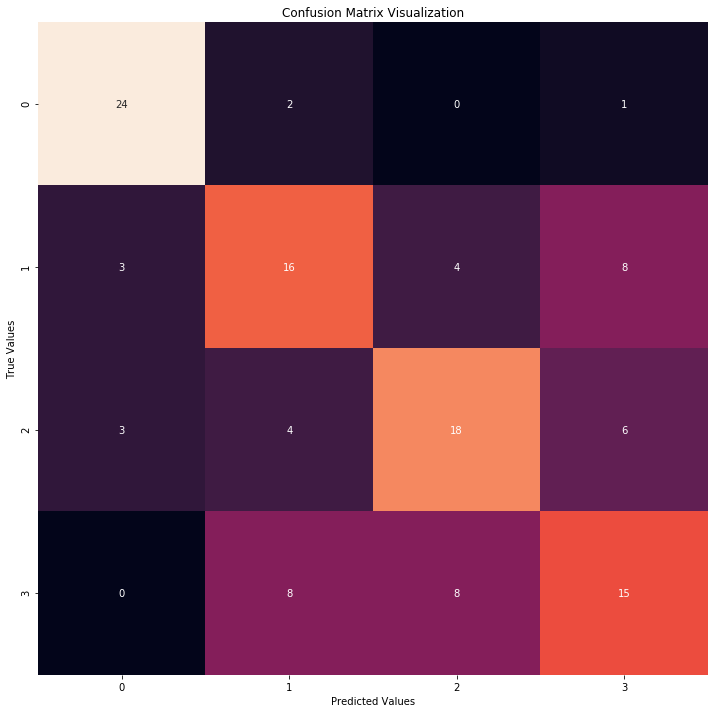

In [22]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cbar=False)
plt.title('Confusion Matrix Visualization')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
'''
From our encoder;
    0 is for common_rust
    1 is for healthy
    2 is for leaf_spot
    3 is for nothern_leaf_blight
'''

In [23]:
#The models precision
precision = precision_score(test_labels, predictions, average='weighted')
round(precision, 2)

0.62

In [24]:
#The models recall
recall = precision_score(test_labels, predictions, average='weighted')
round(recall, 2)

0.62

In [25]:
#The f1 score
f_score = f1_score(test_labels, predictions, average='weighted')
round(f_score, 2)

0.61

In [26]:
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.89      0.80      0.84        30
            healthy       0.52      0.53      0.52        30
          leaf_spot       0.58      0.60      0.59        30
nothern_leaf_blight       0.48      0.50      0.49        30

           accuracy                           0.61       120
          macro avg       0.62      0.61      0.61       120
       weighted avg       0.62      0.61      0.61       120



In [27]:
start = time.time()
hog_knearest_neighbors.fit(X,y)
stop = time.time()
train_time = round((stop - start), 4)
train_time

0.2097

In [28]:
#Accuracy on the test set
predictions = cross_val_predict(hog_knearest_neighbors, test_features, test_labels, cv=10)
accuracy_score(predictions, test_labels)

0.525

In [29]:
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)

#Confusion matrix
cm = confusion_matrix(decoded_predictions, decoded_test_labels, 
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight'])
cm

array([[22,  1,  1,  3],
       [ 2, 20, 12, 13],
       [ 2,  5, 10,  3],
       [ 4,  4,  7, 11]], dtype=int64)

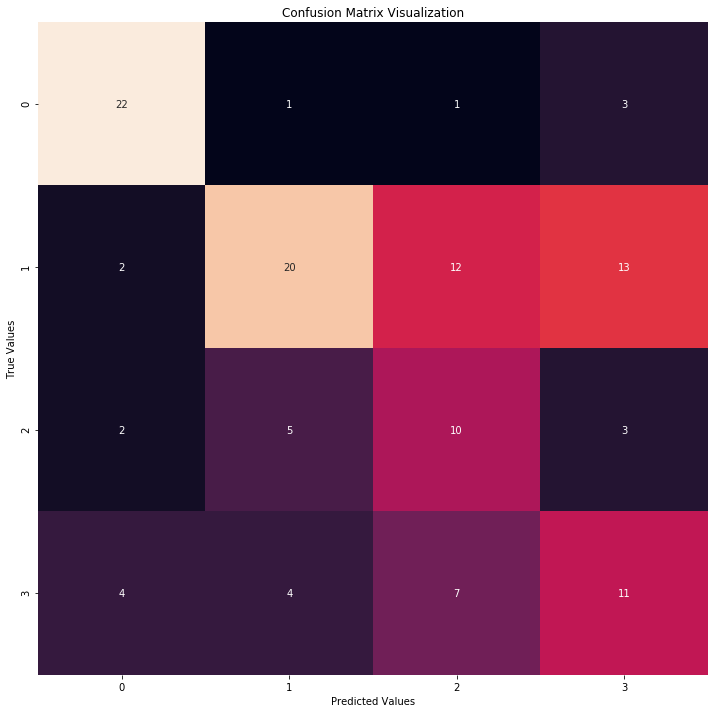

In [30]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cbar=False)
plt.title('Confusion Matrix Visualization')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [31]:

precision = precision_score(test_labels, predictions, average='weighted')
round(precision, 2)

0.54

In [32]:

recall = precision_score(test_labels, predictions, average='weighted')
round(recall, 2)

0.54

In [33]:
f_score = f1_score(test_labels, predictions, average='weighted')
round(f_score, 2)

0.52

In [34]:
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.81      0.73      0.77        30
            healthy       0.43      0.67      0.52        30
          leaf_spot       0.50      0.33      0.40        30
nothern_leaf_blight       0.42      0.37      0.39        30

           accuracy                           0.53       120
          macro avg       0.54      0.52      0.52       120
       weighted avg       0.54      0.53      0.52       120



In [48]:
start = time.time()
hog_linear_svc.fit(X,y)
stop = time.time()
train_time = round((stop - start), 4)
train_time

0.078

In [49]:
#Accuracy on the test set
predictions = cross_val_predict(hog_linear_svc, linear_svc_test_features, test_labels, cv=10)
accuracy_score(predictions, test_labels)

0.6083333333333333

In [50]:
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)

#Confusion matrix
cm = confusion_matrix(decoded_predictions, decoded_test_labels, 
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight'])
cm

array([[24,  1,  2,  2],
       [ 4, 16,  5,  7],
       [ 1,  4, 15,  3],
       [ 1,  9,  8, 18]], dtype=int64)

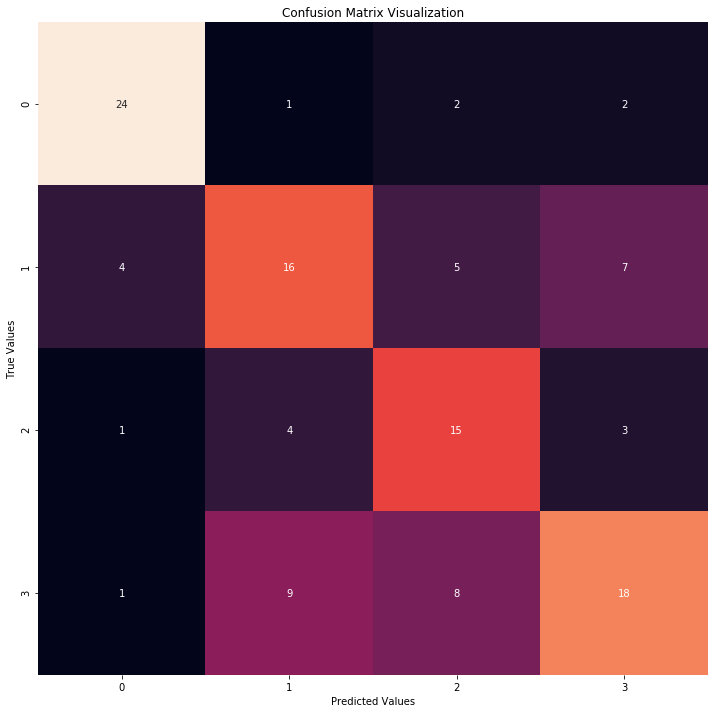

In [51]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cbar=False)
plt.title('Confusion Matrix Visualization')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [52]:

precision = precision_score(test_labels, predictions, average='weighted')
round(precision, 2)

0.62

In [53]:

recall = precision_score(test_labels, predictions, average='weighted')
round(recall, 2)

0.62

In [54]:
f_score = f1_score(test_labels, predictions, average='weighted')
round(f_score, 2)

0.61

In [55]:
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.83      0.80      0.81        30
            healthy       0.50      0.53      0.52        30
          leaf_spot       0.65      0.50      0.57        30
nothern_leaf_blight       0.50      0.60      0.55        30

           accuracy                           0.61       120
          macro avg       0.62      0.61      0.61       120
       weighted avg       0.62      0.61      0.61       120



In [86]:
start = time.time()
hog_svc.fit(X,y)
stop = time.time()
train_time = round((stop - start), 4)
train_time

0.4167

In [87]:
#Accuracy on the test set
predictions = cross_val_predict(hog_svc, svc_test_features, test_labels, cv=10)
accuracy_score(predictions, test_labels)

0.5

In [88]:
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)

#Confusion matrix
cm = confusion_matrix(decoded_predictions, decoded_test_labels, 
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight'])
cm

array([[24,  2,  1,  2],
       [ 3, 15,  5,  9],
       [ 1,  7, 13, 11],
       [ 2,  6, 11,  8]], dtype=int64)

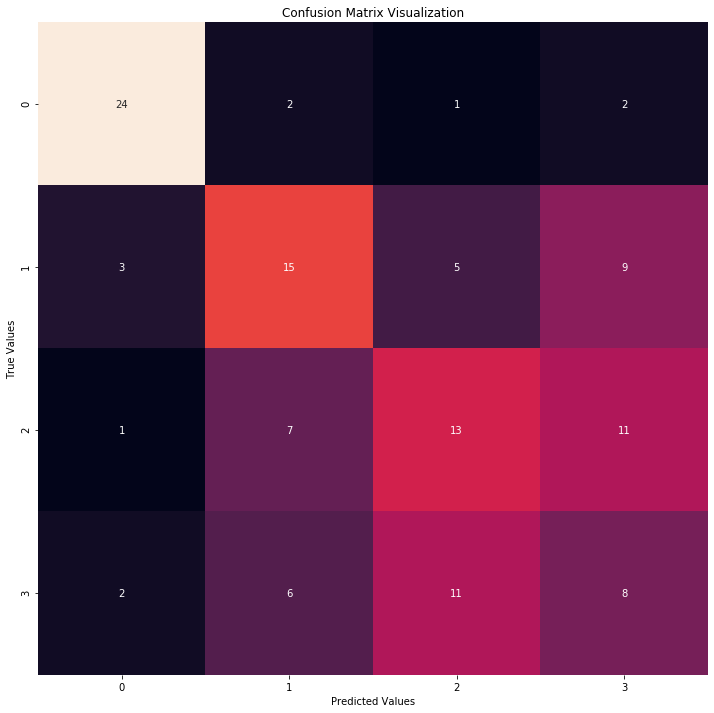

In [89]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cbar=False)
plt.title('Confusion Matrix Visualization')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [90]:

precision = precision_score(test_labels, predictions, average='weighted')
round(precision, 2)

0.5

In [91]:

recall = precision_score(test_labels, predictions, average='weighted')
round(recall, 2)

0.5

In [92]:
f_score = f1_score(test_labels, predictions, average='weighted')
round(f_score, 2)

0.5

In [93]:
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.83      0.80      0.81        30
            healthy       0.47      0.50      0.48        30
          leaf_spot       0.41      0.43      0.42        30
nothern_leaf_blight       0.30      0.27      0.28        30

           accuracy                           0.50       120
          macro avg       0.50      0.50      0.50       120
       weighted avg       0.50      0.50      0.50       120



In [66]:
start = time.time()
hog_random_forest.fit(X,y)
stop = time.time()
train_time = round((stop - start), 4)
train_time

4.6561

In [67]:
#Accuracy on the test set
predictions = cross_val_predict(hog_random_forest, test_features, test_labels, cv=10)
accuracy_score(predictions, test_labels)

0.65

In [68]:
decoded_predictions = encoder.inverse_transform(predictions)
decoded_test_labels = encoder.inverse_transform(test_labels)

#Confusion matrix
cm = confusion_matrix(decoded_predictions, decoded_test_labels, 
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight'])
cm

array([[25,  1,  0,  1],
       [ 1, 18,  5,  6],
       [ 0,  3, 18,  6],
       [ 4,  8,  7, 17]], dtype=int64)

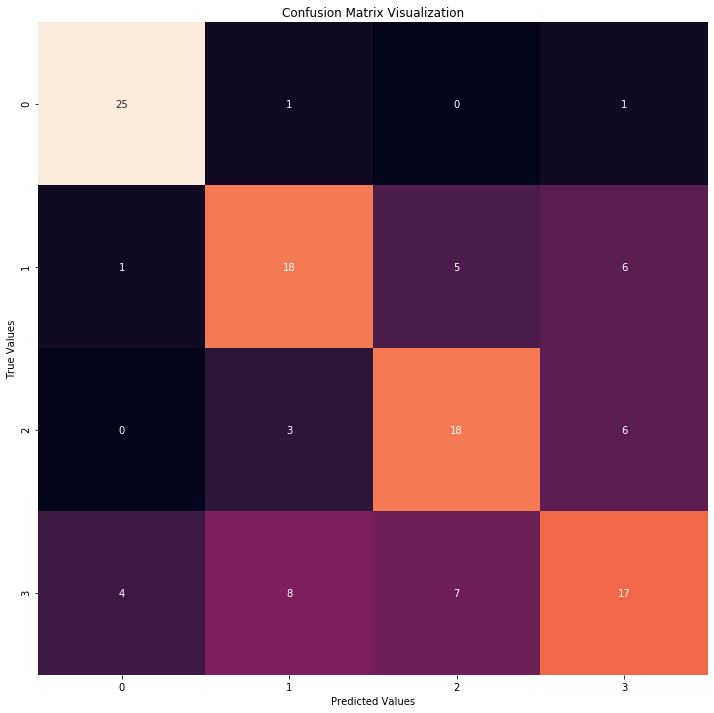

In [69]:
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, cbar=False)
plt.title('Confusion Matrix Visualization')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

In [70]:

precision = precision_score(test_labels, predictions, average='weighted')
round(precision, 2)

0.67

In [71]:

recall = precision_score(test_labels, predictions, average='weighted')
round(recall, 2)

0.67

In [72]:
f_score = f1_score(test_labels, predictions, average='weighted')
round(f_score, 2)

0.66

In [73]:
print(classification_report(decoded_test_labels, decoded_predictions,  
                      labels=['common_rust', 'healthy', 'leaf_spot', 'nothern_leaf_blight']))

                     precision    recall  f1-score   support

        common_rust       0.93      0.83      0.88        30
            healthy       0.60      0.60      0.60        30
          leaf_spot       0.67      0.60      0.63        30
nothern_leaf_blight       0.47      0.57      0.52        30

           accuracy                           0.65       120
          macro avg       0.67      0.65      0.66       120
       weighted avg       0.67      0.65      0.66       120



In [ ]:
'''
These models perform very badly on the test set. This shows that the models do not generalize well and likely overfit
on the training data. To deal with this, we will increse the traiing data in the next notebook
'''

In [ ]:
'''
Let us ensemble the modles and find the perfomance
'''

In [74]:
from sklearn.ensemble import VotingClassifier

In [95]:
estimators = [
    ('Random Forest', hog_random_forest),
    ('Logistic Regression', hog_logistic_regression),
    ('K-Nearest Neighbor', hog_knearest_neighbors),
    #('Linear SVC', hog_linear_svc),
    ('Support Vector Classifier', hog_svc)
]

In [96]:
voting_classifier = VotingClassifier(
    estimators=estimators,
    voting='soft'
)
voting_classifier.fit(X,y)
accuracy = voting_classifier.score(test_features, test_labels)
round(accuracy, 2)

0.58

In [ ]:
#Stil performs poorly